In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
from omegaconf import OmegaConf
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
import numpy as np
from sklearn import metrics
from torch.nn import BatchNorm2d

ImportError: cannot import name 'initialize' from 'hydra' (/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/hydra/__init__.py)

In [5]:
#!pip install hydra-core --upgrade

In [6]:
with initialize(config_path="../configs/exp_multi_cqt"):
    cfg = compose(config_name="01_b0_512_5cqt", overrides= 
                  [
                      "+INPUT_PATH=../input", 
                      "+STEPS_PER_EPOCH=0",
                      "+NUM_WORKERS=12",
                  ])
    print(cfg)

{'EXP_NAME': '00_b0_512_5cqt', 'FOLD': 0, 'BS': 32, 'FP16': False, 'EPOCH': 7, 'TRAIN_FOLD': -1, 'MODEL': {'NAME': 'CustomModel_v2', 'CFG': {'encoder': 'efficientnet_b0', 'img_w': 512, 'img_h': 512, 'cqt_params': [{'sr': 2048, 'fmin': 20, 'fmax': 1024, 'hop_length': 32, 'bins_per_octave': 8}, {'sr': 2048, 'fmin': 20, 'fmax': 1024, 'hop_length': 128, 'bins_per_octave': 24}, {'sr': 2048, 'fmin': 20, 'fmax': 1024, 'hop_length': 128, 'bins_per_octave': 4}, {'sr': 2048, 'fmin': 20, 'fmax': 1024, 'hop_length': 16, 'bins_per_octave': 24}, {'sr': 2048, 'fmin': 20, 'fmax': 1024, 'hop_length': 16, 'bins_per_octave': 4}]}}, 'TRANSFORM': {'NAME': 'src.transforms.minmax_turkey_bandpass_transform', 'CFG': {'lf': 30, 'hf': 400}}, 'SCHEDULER': {'NAME': 'torch.optim.lr_scheduler.CosineAnnealingLR', 'CFG': {'T_max': 9}}, 'N_SAVED': 5, 'TENSORBOARD_DIR': '/home/trytolose/rinat/kaggle/grav_waves_detection/logs/tensorboard_grid', 'INPUT_PATH': '../input', 'STEPS_PER_EPOCH': 0, 'NUM_WORKERS': 12}


In [7]:
!ls -l ../configs/exp_multi_cqt

total 48
-rw-rw-r-- 1 trytolose trytolose 1862 сен 15 23:04 00_b0_128_5cqt.yaml
-rw-rw-r-- 1 trytolose trytolose 1114 сен 11 00:34 01_b0_512_5cqt.yaml
-rw-rw-r-- 1 trytolose trytolose 1113 сен 12 00:22 02_b4_512_5cqt.yaml
-rw-rw-r-- 1 trytolose trytolose 1112 сен 12 11:17 03_rexnet_512_5cqt.yaml
-rw-rw-r-- 1 trytolose trytolose 1124 сен 12 19:18 04_test_scaler.yaml
-rw-rw-r-- 1 trytolose trytolose 1124 сен 13 15:33 05_256x512_b4_f32.yaml
-rw-rw-r-- 1 trytolose trytolose 1130 сен 13 17:01 06_512x512_b4_f16_scaler.yaml
-rw-rw-r-- 1 trytolose trytolose 1141 сен 14 02:19 07_512x512_seresnext50_f16_scaler.yaml
-rw-rw-r-- 1 trytolose trytolose 1450 сен 14 18:12 08_512x512_seresnext50_f32.yaml
-rw-rw-r-- 1 trytolose trytolose 1845 сен 15 11:32 09_512x512_b4_f16_disable_bn_after1.yaml
-rw-rw-r-- 1 trytolose trytolose 1820 сен 15 23:23 09_512x512_resnet18d.yaml
-rw-rw-r-- 1 trytolose trytolose  624 сен 15 22:32 10_cwt.yaml


In [8]:
import torch
import torch.nn as nn
from tqdm import tqdm
import sys
sys.path.insert(0, "../")
from src.models import get_model
from src.dataset import get_loaders

In [9]:
model = get_model(cfg)
model.cuda()
print()

CQT kernels created, time used = 0.0082 seconds
CQT kernels created, time used = 0.0197 seconds
CQT kernels created, time used = 0.0022 seconds
CQT kernels created, time used = 0.0199 seconds
CQT kernels created, time used = 0.0023 seconds


/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


In [14]:
!ls -l ../weights/CustomModel_v2/00_b0_512_5cqt/fold_0/best_avg_score0.87643.pth

total 180876
-rw-r--r-- 1 trytolose trytolose 26454622 сен 11 18:54 best_avg_score0.87643.pth
-rw-rw-r-- 1 trytolose trytolose 26457043 сен 11 02:36 cp_epoch01_score0.87247.pth
-rw-rw-r-- 1 trytolose trytolose 26457043 сен 11 03:35 cp_epoch02_score0.87510.pth
-rw-rw-r-- 1 trytolose trytolose 26457043 сен 11 04:34 cp_epoch03_score0.87411.pth
-rw-rw-r-- 1 trytolose trytolose 26457043 сен 11 05:33 cp_epoch04_score0.87446.pth
-rw-rw-r-- 1 trytolose trytolose 26457043 сен 11 06:32 cp_epoch05_score0.87558.pth
-rw-rw-r-- 1 trytolose trytolose 26457043 сен 11 07:31 cp_epoch06_score0.87478.pth


In [15]:
model.load_state_dict(torch.load("../weights/CustomModel_v2/00_b0_512_5cqt/fold_0/best_avg_score0.87643.pth"))

# model.max = torch.tensor([[1.0152528, 1.0579135, 4.407389, 0.6678433, 0.6959216, 2.6014798,
#  0.96952397, 0.99088365, 4.4576807,  0.67043734, 0.6968712,  2.6080358,
#  1.0269003,  1.0014149,  4.6485667, ]]).cuda()
# model.min = torch.tensor([0]*15).cuda()

<All keys matched successfully>

In [16]:
_, val_loader = get_loaders(cfg)

           id  target                                 path  fold
0  0000661522       0  ../input/train/0/0/0/0000661522.npy     4
1  00007a006a       0  ../input/train/0/0/0/00007a006a.npy     3
2  0000c3b9c9       0  ../input/train/0/0/0/0000c3b9c9.npy     4
3  000118b40d       0  ../input/train/0/0/0/000118b40d.npy     1
4  0001388506       1  ../input/train/0/0/0/0001388506.npy     2


In [17]:
loss_fn = torch.nn.BCEWithLogitsLoss()

val_loss = []

val_true = []
val_pred = []

model.eval()
with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(val_loader), ncols=50, leave=False, total=len(val_loader)):
        x = x.cuda().float()
        y = y.cuda().float().unsqueeze(1)
        pred = model(x)
        loss = loss_fn(pred, y)
        val_loss.append(loss.item())

        pred = pred.sigmoid().cpu().data.numpy()
        val_pred.append(pred)
        val_true.append(y.cpu().numpy())

val_loss = np.mean(val_loss)
val_true = np.concatenate(val_true).reshape(
    -1,
)
val_pred = np.concatenate(val_pred).reshape(
    -1,
)

final_score = metrics.roc_auc_score(val_true, val_pred)

In [18]:
final_score

0.8764338153000727

In [18]:
final_score

0.5

In [19]:
val_pred

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [12]:
x = torch.rand(7, 15, 512, 512).cuda()

In [13]:
# model.cpu()
model.eval()
print()

In [14]:
model.model(x)

tensor([[2525.4871],
        [2513.1792],
        [2504.0283],
        [2512.6169],
        [2490.4517],
        [2481.3140],
        [2474.9202]], device='cuda:0', grad_fn=<AddmmBackward>)

In [16]:
import torch
from torchvision.models.resnet import resnet18

resnet = resnet18(pretrained=True)
resnet.fc = torch.nn.Linear(512, 10)

inputs = torch.randn((124, 3, 32, 32), requires_grad=False).cuda()

resnet.cuda()
resnet.eval()
with torch.cuda.amp.autocast(enabled=True):
    outputs = resnet(inputs)

print(outputs)

tensor([[ 0.0487,  0.2393,  0.9897,  ..., -0.5146, -0.1462,  0.0931],
        [-0.0769,  0.1199,  0.7578,  ..., -0.3232, -0.1769, -0.1326],
        [-0.2018,  0.2678,  0.9995,  ..., -0.6514, -0.0749,  0.1461],
        ...,
        [-0.0280,  0.0661,  0.7461,  ..., -0.3657, -0.3528, -0.1846],
        [-0.1705,  0.0226,  0.6021,  ..., -0.3489, -0.2014, -0.1578],
        [-0.1978, -0.0457,  0.8086,  ..., -0.3740, -0.1035, -0.1017]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddmmBackward>)


In [4]:
# import torch
# import torch.nn as nn
# import timm

# class CustomModel_v1(nn.Module):
#     def __init__(self, cfg, pretrained=False):
#         super().__init__()
#         self.model = timm.create_model("efficientnet_b0", pretrained=pretrained, in_chans=3, num_classes=1)
#         self.cqt = CQT1992v2(**cfg.qtransform_params)
#         self.h, self.w = 256, 256

#     def forward(self, x):
#         bs, ch, sig_len = x.shape
#         x = x.view(-1, sig_len)
#         x = self.cqt(x).unsqueeze(1)
#         x = nn.functional.interpolate(x, (self.h, self.w))
#         _, _, h, w = x.shape
#         x = x.view(bs, 3, h, w)
#         output = self.model(x)
#         return output


In [5]:
class CFG:
    def __init__(self):
        self.qtransform_params = {
            'sr': 2048,
            'fmin': 20,
            'fmax': 1024,
            'hop_length': 32,
            'bins_per_octave': 8,
        }

        self.bandpass_param = {
          'lf': 30,
          'hf': 400,
          'order': 8, 
          'sr': 2048,
        }
cfg = CFG()

In [6]:
df = pd.read_csv(INPUT_PATH / "sample_submission.csv")

files = list((INPUT_PATH / "test").rglob("*.npy"))
FILE_PATH_DICT = {x.stem: str(x) for x in files}
df["path"] = df["id"].apply(lambda x: FILE_PATH_DICT[x])

In [7]:
# model = CustomModel_v1(encoder='rexnet_150', img_h=512, img_w=512,).cuda()
# # model = Andrewnet_v3_true().cuda()
# transform_f = partial(minmax_bandpass_transform, params=cfg.bandpass_param)
# val_ds = TrainDataset(
#     df,
#     mode="test",
#     transform=transform_f,
# )
# val_loader = DataLoader(val_ds, shuffle=False, num_workers=12, batch_size=64, pin_memory=False)
# total_predicts = []
# for f in range(1):
#     model.load_state_dict(torch.load(f"../weights/CustomModel_v1/011_rexnet150_bandpass_fp16_cos_5_radam_512_2021-08-30-09-11-44/fold_0/cp_epoch03_score0.87290.pth"))
# #     model.load_state_dict(torch.load(f"/home/trytolose/rinat/kaggle/grav_waves_detection/weights/Wavenet/010_wavenet_bandpass_fp32_cos_10_2021-08-30-05-38-05/fold_0/cp_epoch08_score0.86815.pth"))
#     val_pred = []
#     model.eval()
#     with torch.no_grad():
#         for x in tqdm(val_loader, ncols=50, leave=True):
#             x = x.cuda().float()
#             pred = model(x)
#             pred = pred.sigmoid().cpu().data.numpy()
#             val_pred.append(pred)
            
#     val_pred = np.concatenate(val_pred).reshape(-1,)
#     total_predicts.append(val_pred)

CQT kernels created, time used = 0.0061 seconds


/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
100%|█████████| 3532/3532 [12:12<00:00,  4.82it/s]


In [8]:
paths = [
    "../weights/Wavenet/010_wavenet_bandpass_fp32_cos_10_2021-08-30-05-38-05/fold_0/cp_epoch08_score0.86815.pth",
    "../weights/Wavenet/028_wavenet_bandpass_fp32_cos_10_best.yaml/fold_1/cp_epoch11_score0.86439.pth",
    "../weights/Wavenet/028_wavenet_bandpass_fp32_cos_10_best.yaml/fold_2/cp_epoch11_score0.86913.pth",
    "../weights/Wavenet/028_wavenet_bandpass_fp32_cos_10_best.yaml/fold_3/cp_epoch10_score0.86845.pth",
    "../weights/Wavenet/028_wavenet_bandpass_fp32_cos_10_best.yaml/fold_4/cp_epoch10_score0.86553.pth",
]

In [9]:
# model = CustomModel_v1().cuda()
model = Andrewnet_v3_true().cuda()
transform_f = partial(minmax_bandpass_transform)

val_ds = TrainDataset(
    df,
    mode="test",
    transform=transform_f,
)
val_loader = DataLoader(val_ds, shuffle=False, num_workers=12, batch_size=64, pin_memory=False)
total_predicts = []

for w_path in paths:
    model.load_state_dict(torch.load(w_path))
    val_pred = []
    model.eval()
    with torch.no_grad():
        for x in tqdm(val_loader, ncols=50, leave=True):
            x = x.cuda().float()
            pred = model(x)
            pred = pred.sigmoid().cpu().data.numpy()
            val_pred.append(pred)
            
    val_pred = np.concatenate(val_pred).reshape(-1,)
    total_predicts.append(val_pred)

100%|█████████| 3532/3532 [03:48<00:00, 15.48it/s]


In [10]:
total_predicts = np.stack(total_predicts)

In [11]:
total_predicts.shape

(5, 226000)

In [12]:
df['target'] = total_predicts.mean(axis=0)

In [13]:
df = df.drop("path", axis=1)

In [14]:
df

,id,target
0,00005bced6,0.999924
1,0000806717,0.988476
2,0000ef4fe1,0.241230
3,00020de251,0.537449
4,00024887b5,0.166916
...,...,...
225995,ffff4125f1,0.351886
225996,ffff9d32a6,0.355625
225997,ffff9f4c1f,0.239442
225998,ffffa19693,0.999924


In [15]:
df.to_csv("submission_wavenet_01234.csv", index=False)

In [113]:
df_rex = pd.read_csv("submission_rexnet150.csv")

In [114]:
df_blend = df.copy()

In [115]:
df_blend['target'] = 0.5* df['target'] + 0.5*df_rex['target']
df_blend.to_csv("submission_blend.csv", index=False)

In [16]:
!kaggle competitions submit -c g2net-gravitational-wave-detection -f submission_wavenet_01234.csv -m "submission_wavenet_01234"

100%|██████████████████████████████████████| 4.66M/4.66M [00:03<00:00, 1.33MB/s]
Successfully submitted to G2Net Gravitational Wave Detection

In [ ]:
df_top_fp=df[df['target']==0].sort_values("target_pred", ascending=False)[:10]
df_top_fp.to_csv("top_10_fp.csv", index=False)

In [ ]:
df_min = df.sort_values("target_pred")[:10].copy()
df_max = df.sort_values("target_pred", ascending=False)[:10].copy()

In [ ]:
df_max

In [ ]:
df_total = pd.concat([df_max, df_min], ignore_index=True)
df_total.to_csv("top_min_max.csv", index=False)

In [ ]:
!nvidia-smi

In [3]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [36]:
from torch.optim import Adam
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR
import matplotlib.pyplot as plt
from timm.scheduler import CosineLRScheduler

model = models.resnet18()
optimizer = Adam(model.parameters(), lr=0.001)

In [69]:
lrs = []
scheduler = CosineLRScheduler(optimizer, 30, t_mul=1, warmup_t=15, cycle_limit=1)
# scheduler = CosineAnnealingWarmRestarts(optimizer, 5, 1)
# scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
# print(scheduler.T_max)
lrs.append(get_lr(optimizer))
for epoch in range(200):
#     for i in range(3500):
    optimizer.step()
#         if epoch < 5:
#         scheduler.step(epoch + i / 3500)
    lrs.append(get_lr(optimizer))
    scheduler.step(epoch)

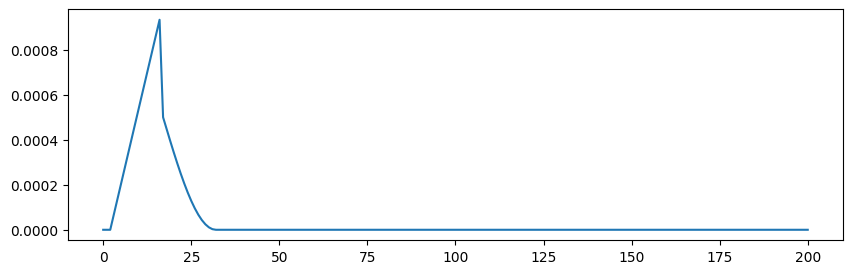

In [70]:
plt.figure(figsize=(10,3))
plt.plot(lrs)
plt.show()

In [96]:
lrs = []
scheduler = CosineLRScheduler(optimizer, t_initial=7, t_mul=3, warmup_t=1, cycle_limit=1, decay_rate=0.0001)
# scheduler = CosineAnnealingWarmRestarts(optimizer, 5, 1)
# scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
# print(scheduler.T_max)
lrs.append(get_lr(optimizer))
for epoch in range(10):
    for i in range(3500):
        optimizer.step()
#         if epoch < 5:
        scheduler.step(epoch + i / 3500)
        lrs.append(get_lr(optimizer))
        scheduler.step(epoch)

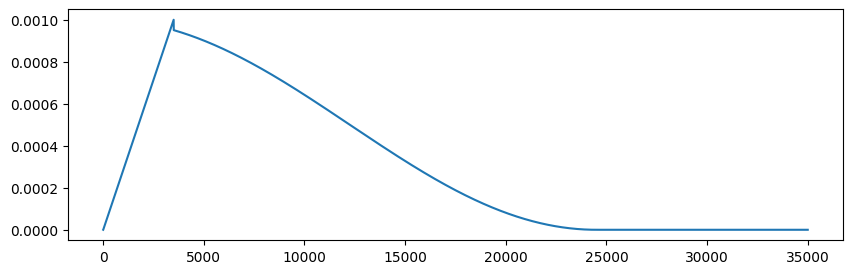

In [97]:
plt.figure(figsize=(10,3))
plt.plot(lrs)
plt.show()

In [16]:
X_std = (x - np.array([0, 0, 0])) / 10
X_scaled = X_std * (2) - 1

In [14]:
!ls -l 

total 166832
-rw-rw-r-- 1 trytolose trytolose  2560697 авг 16 20:00 baseline_f0.pt
-rw-rw-r-- 1 trytolose trytolose    20202 авг 27 00:44 baseline.ipynb
-rw-rw-r-- 1 trytolose trytolose     6570 авг 28 16:19 baseline.py
-rw-rw-r-- 1 trytolose trytolose    70736 сен 10 01:07 inference.ipynb
-rw-rw-r-- 1 trytolose trytolose  4480128 сен  5 22:17 oof_eff0_v2.npy
-rw-rw-r-- 1 trytolose trytolose    17640 сен  5 22:16 OOF.ipynb
-rw-rw-r-- 1 trytolose trytolose 14174282 авг 28 00:37 OOF_pred_turkey_bandpass.csv
-rw-rw-r-- 1 trytolose trytolose      607 авг 14 14:14 scaler.pkl
-rw-rw-r-- 1 trytolose trytolose  6852473 сен  5 22:29 submission_blend.csv
-rw-rw-r-- 1 trytolose trytolose  4754872 авг 28 12:14 submission.csv
-rw-rw-r-- 1 trytolose trytolose  4888393 сен 10 01:04 submission_lb_0.8732.csv
-rw-rw-r-- 1 trytolose trytolose  4894101 авг 30 20:33 submission_rexnet150.csv
-rw-rw-r-- 1 trytolose trytolose  4878213 авг 28 18:49 submission_wave.csv
-rw-rw-r-- 1 trytolose trytolose  4886028 

In [21]:
df = pd.read_csv("submission_lb_0.8732.csv")
df_best = pd.read_csv("submission_blend.csv")

In [22]:
df['target'] = 0.3*df['target'] + 0.7*df_best['target'] 

In [23]:
df.to_csv("submit_best.csv", index=False)

In [11]:
!ls ../weights/CustomModel_v1/00_b0_128_best/fold_1/cp_epoch04_score0.87044.pth

best_avg_score0.87182.pth    cp_epoch05_score0.87034.pth
cp_epoch02_score0.87019.pth  cp_epoch06_score0.86905.pth
cp_epoch04_score0.87044.pth


In [24]:
!kaggle competitions submit -c g2net-gravitational-wave-detection -f submit_best.csv -m "blend best"

100%|██████████████████████████████████████| 6.54M/6.54M [00:05<00:00, 1.36MB/s]
Successfully submitted to G2Net Gravitational Wave Detection

In [2]:
!ls -l /home/trytolose/rinat/kaggle/grav_waves_detection/weights/CustomModel_v2/09_512x512_resnet18d

total 23420
drwxrwxr-x 2 trytolose trytolose     4096 сен 16 22:02 fold_0
drwxrwxr-x 2 trytolose trytolose     4096 сен 16 22:19 fold_1
drwxrwxr-x 2 trytolose trytolose     4096 сен 16 22:36 fold_2
drwxrwxr-x 2 trytolose trytolose     4096 сен 16 22:53 fold_3
drwxrwxr-x 2 trytolose trytolose     4096 сен 16 23:11 fold_4
-rw-rw-r-- 1 trytolose trytolose 23960338 сен 17 00:40 submission.csv


In [40]:
import pandas as pd

In [35]:
df_r18 = pd.read_csv("/home/trytolose/rinat/kaggle/grav_waves_detection/weights/CustomModel_v2/09_512x512_resnet18d/submission.csv")

In [36]:
df_r18['target'] = df_r18.iloc[:, 2:].mean(axis=1)
df_r18 = df_r18[['id', 'target']].copy()

In [37]:
df_512 = pd.read_csv("/home/trytolose/rinat/kaggle/grav_waves_detection/weights/CustomModel_v2/00_b0_512_5cqt/submission.csv")
df_wav = pd.read_csv("submission_wavenet_023.csv")

In [38]:
df_r18['target'] = 0.6*df_512['target'] + 0.4*df_r18['target'] # + 0.1* df_wav['target']

In [39]:
df_r18.to_csv("submission.csv", index=False)
!kaggle competitions submit -c g2net-gravitational-wave-detection -f submission.csv -m "cqt5_r18_b0_wavenet"

100%|██████████████████████████████████████| 6.48M/6.48M [00:05<00:00, 1.24MB/s]
Successfully submitted to G2Net Gravitational Wave Detection

In [15]:
df_r18

,id,target
0,00005bced6,1.000000
1,0000806717,0.830115
2,0000ef4fe1,0.324190
3,00020de251,0.831102
4,00024887b5,0.121865
...,...,...
225995,ffff4125f1,0.292979
225996,ffff9d32a6,0.251123
225997,ffff9f4c1f,0.209423
225998,ffffa19693,0.999995


In [3]:
df_512 = pd.read_csv("/home/trytolose/rinat/kaggle/grav_waves_detection/weights/CustomModel_v2/00_b0_512_5cqt/submission.csv")
df_wav = pd.read_csv("submission_wavenet_023.csv")

In [4]:
# mask_unconf = (df_512['target']>0.2) & (df_512['target']<0.8)

In [5]:
# df_512.loc[mask_unconf, 'target'] = 0.8*df_512.loc[mask_unconf, 'target'] + 0.2* df_wav.loc[mask_unconf, 'target']

In [6]:
df_512['target'] = 0.8*df_512['target'] + 0.2* df_wav['target']

In [7]:
df_512.to_csv("cqt5_plus_wavenet_08_02.csv", index=False)

In [8]:
!kaggle competitions submit -c g2net-gravitational-wave-detection -f cqt5_plus_wavenet_08_02.csv -m "cqt5_plus_wavenet_08_02"

100%|██████████████████████████████████████| 5.63M/5.63M [00:03<00:00, 1.61MB/s]
Successfully submitted to G2Net Gravitational Wave Detection

In [42]:
df = pd.read_csv("/home/trytolose/rinat/kaggle/grav_waves_detection/weights/CustomModel_v2/12_b0_128_5cqt_easy_hard/submission.csv")
df['target'] = df['fold_0']
df = df[['id', 'target']].copy()
df

,id,target
0,00005bced6,0.999939
1,0000806717,0.904104
2,0000ef4fe1,0.341479
3,00020de251,0.995636
4,00024887b5,0.178269
...,...,...
225995,ffff4125f1,0.379723
225996,ffff9d32a6,0.280658
225997,ffff9f4c1f,0.302131
225998,ffffa19693,0.999989


In [43]:
df_r18.to_csv("submission.csv", index=False)
!kaggle competitions submit -c g2net-gravitational-wave-detection -f submission.csv -m "128_3_cls"

100%|██████████████████████████████████████| 6.48M/6.48M [00:03<00:00, 1.70MB/s]
Successfully submitted to G2Net Gravitational Wave Detection

In [25]:
x = torch.rand(13, 15, 256, 256)
t_max = torch.tensor([1.1]*15)
t_max[3] = 0.9


In [34]:
if (x.amax(dim=(0, 2,3)) > t_max).sum() < 1:
    print("here")

In [26]:
t_max

tensor([1.1000, 1.1000, 1.1000, 0.9000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000,
        1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000])

In [5]:
import timm

In [6]:
model = timm.create_model("efficientnet_b4")

In [7]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
 